In [1]:
import os, pathlib

file_path = os.path.dirname(os.path.realpath("__file__"))
home_dir = pathlib.Path(file_path).parent.parent.parent
os.chdir(home_dir)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from src.common import get_optimizer
from src.fashion_mnist.data import get_fashion_mnist_train_test, get_fashion_mnist_labels_categorical
from src.fashion_mnist.file_names import SAVED_CLASSIFIER_PATH
from src.vae import ClaDecVAE

tf.random.set_seed(1234)

train_images, test_images = get_fashion_mnist_train_test()
train_images = np.expand_dims(train_images, -1).astype("float32")  # hack needed for VAE layers
train_labels_c, test_labels_c = get_fashion_mnist_labels_categorical()
# get the trained model and check accuracy on test data for later reference
classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH)

2022-07-05 18:21:29.986377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 18:21:30.019231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 18:21:30.019444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 18:21:30.020037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
classifier.evaluate(test_images, test_labels_c)
classifier.summary()

2022-07-05 18:21:32.121784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


313/313 [==============================] - 3s 4ms/step - loss: 0.2431 - categorical_accuracy: 0.9185
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)     

In [4]:
layer_name = 'dense'
alpha = 0.9
latent_dim = 2
optimizer = get_optimizer()
claDec = ClaDecVAE(classifier, layer_name, alpha, latent_dim)
claDec.compile(optimizer=get_optimizer())

In [5]:
claDec.fit(train_images, train_labels_c, epochs=10)

Epoch 1/10


2022-07-05 18:21:34.095627: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-07-05 18:21:34.331718: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 22s 11ms/step - loss: 30451274.1010 - reconstruction_loss: 381.1410 - kl_loss: 9774865.0000 - classification_loss: 0.3959
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 164409.2181 - reconstruction_loss: 315.2071 - kl_loss: 136969.4844 - classification_loss: 0.3981
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 59165.1405 - reconstruction_loss: 306.8417 - kl_loss: 49597.0391 - classification_loss: 0.3934
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 39259.5880 - reconstruction_loss: 302.8770 - kl_loss: 20358.5508 - classification_loss: 0.3971
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 7943.4242 - reconstruction_loss: 300.6789 - kl_loss: 8215.9199 - classification_loss: 0.4011
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 4464.4902 - reconstruction_loss: 298.4191 - kl_loss: 3227.1501 

In [6]:
classifier.evaluate(test_images, test_labels_c)  # classifier weights not altered

313/313 [==============================] - 1s 4ms/step - loss: 0.2431 - categorical_accuracy: 0.9185


[0.24305014312267303, 0.9185000061988831]

1/1 [==============================] - 0s 17ms/step


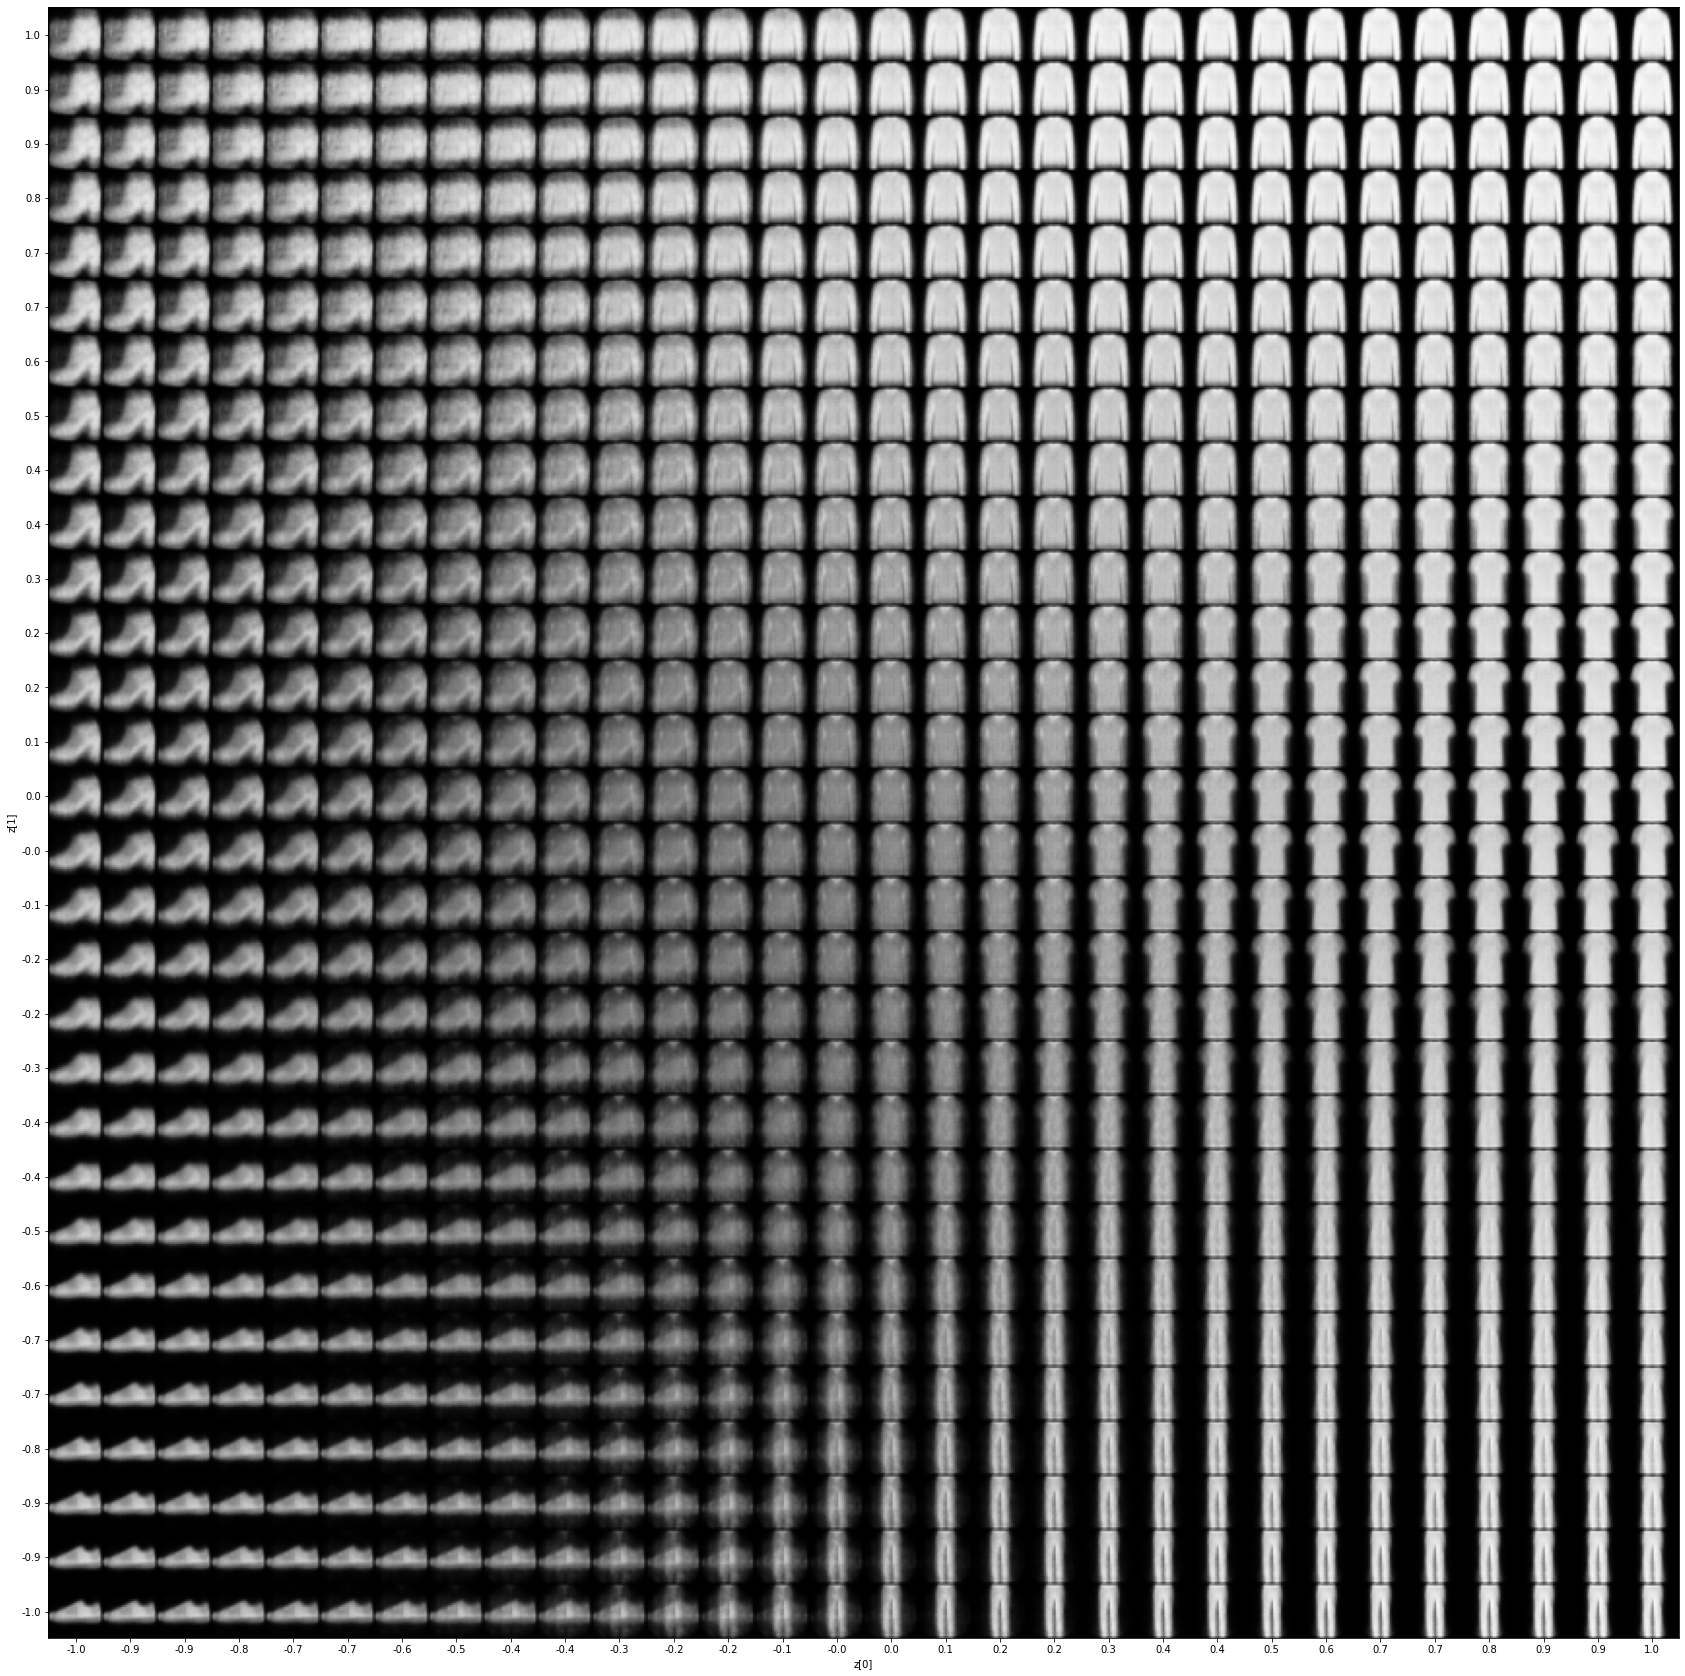

In [7]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=30):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
            i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(claDec)

2022-07-05 18:25:49.089362: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-05 18:25:49.089432: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-05 18:25:49.089452: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-05 18:25:49.673596: W tensorflow/core/common_runtime/bfc_allocato

313/313 [==============================] - 0s 1ms/step


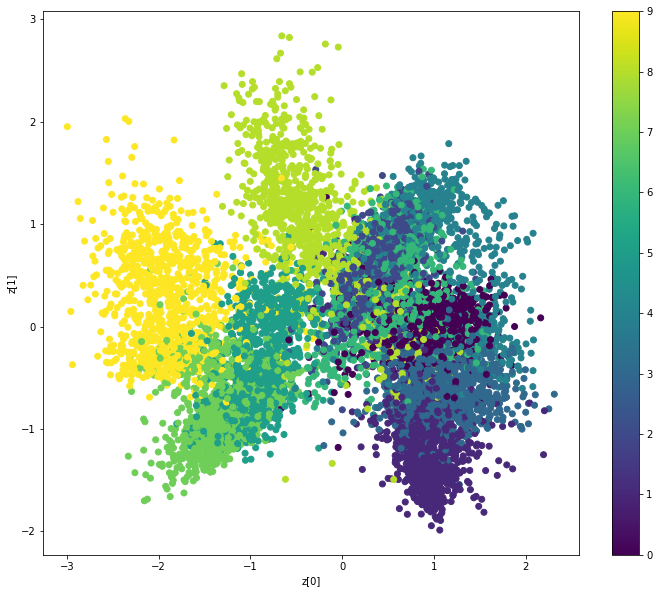

In [8]:
def plot_label_clusters(vae, data, classes):
    # display a 2D plot of the digit classes in the latent space
    acts = vae.model_up_to_layer_to_explain(data)
    z_mean, _, _ = vae.encoder.predict(acts)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=classes)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


test_labels = np.argmax(test_labels_c, axis=1)
train_labels = np.argmax(train_labels_c, axis=1)
encoding = ["T-Shirt (Top)", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
plot_label_clusters(claDec, train_images[:10000], train_labels[:10000])

313/313 [==============================] - 0s 1ms/step


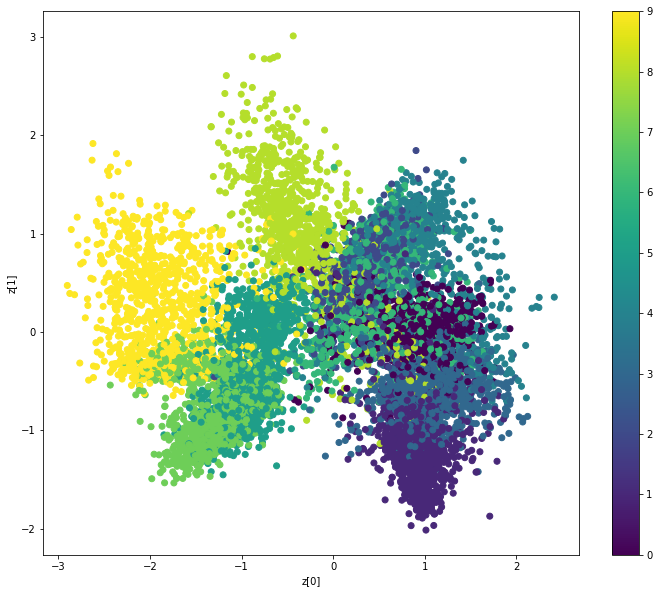

In [9]:
plot_label_clusters(claDec, test_images, test_labels)